In this notebook, we will investigate the Zero-Noise Extrapolation Model and apply it to some circuits and see how it benefits us

In [ ]:
!pip3 install qiskit-aer-gpu

In [ ]:
!pip3 install qiskit_optimization
!pip3 install qiskit
!pip3 install qiskit_aer
!pip3 install qiskit_ibm_runtime
!pip3 install qiskit_optimization


In [1]:
#My token number is removed to ensure privacy
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="TOKEN",overwrite = True)
service = QiskitRuntimeService(channel="ibm_quantum")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import scipy.optimize as opt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator

In [3]:
backend = service.least_busy(operational=True, simulator=False)
backend

<IBMBackend('ibm_brisbane')>

In [11]:
import numpy as np
import warnings

warnings.filterwarnings("ignore")

from qiskit_optimization.applications import Maxcut

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_aer.noise import *
import qiskit_aer.noise as noise


# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import networkx as nx
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [12]:
def unitary_folding(qc,num):
  '''
  Function that applies unitary folding to a quantum circuit
  Inputs:
    qc: quantum circuit object (from qiskit)
    num: number of times the circuit is folded
  Outputs:
    qc: a quantum circuit that has been folded
  '''
  inverse = qc.inverse()
  temp_circ = qc&inverse
  if num>0:
    for i in range(num-1):
      temp_circ&=temp_circ
  temp_circ&=qc
  return temp_circ

In [13]:
#I will first simply implement this directly without a function
#In the future I hope to be able to adapt this to be similar to mitiq's
#Problem: Maxcut
#Problem instance:
num_nodes = 6
graph = nx.Graph()
#Add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),(1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
graph.add_weighted_edges_from(edges)
#For this, we will set the depth of the circuit as p = 3, such that it is deep enough for error to accumulate but not so deep that it is unreasonable
p = 3

maxcut = Maxcut(graph)
qubo = maxcut.to_quadratic_program()
ising = qubo.to_ising()

ansatz = QAOAAnsatz(ising[0], reps=3)





In [14]:
ising[1]

-16.0

In [15]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.063   # 2-qubit gate


# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3','x','z','y','H'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx','cz'])

In [16]:
#real_backend = service.backend("ibm_brisbane")
backend = AerSimulator(noise_model=noise_model)
backend.set_options(device='GPU')
print(backend.available_devices())
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=0)
ansatz_isa = pm.run(ansatz)
#ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

hamiltonian_isa = ising[0].apply_layout(ansatz_isa.layout)
#hamiltonian_isa

('CPU', 'GPU')


In [17]:
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(ising[0])

x = maxcut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + ising[1])
print("solution:", x)
print("solution objective:", qubo.objective.evaluate(x))

energy: -7.0
max-cut objective: -23.0
solution: [0. 1. 0. 0. 1. 1.]
solution objective: 23.0


In [18]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [8]:
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
#estimator.options.dynamical_decoupling.enable = True
callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)

NameError: name 'backend' is not defined

In [27]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA",callback=callback)

In [35]:
res[]

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.068115234375
       x: [ 1.352e+00  5.910e+00  5.157e+00  2.308e+00  1.018e+00
            2.115e+00]
    nfev: 65
   maxcv: 0.0

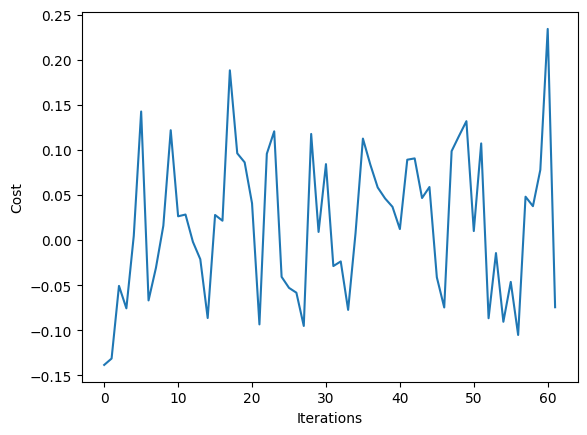

In [28]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [19]:
#Applying ZNE
qcs = [ansatz_isa]
result = []
for i in range(2,6):
  qcs.append(unitary_folding(ansatz,i))

#Running the noiseless simulator
noiseless_backend = AerSimulator()
noiseless_backend.set_options(device = 'GPU')
t_noiseless = noiseless_backend.target
pm_noiseless = generate_preset_pass_manager(target=target, optimization_level=0)
ansatz_isa_noiseless = pm_noiseless.run(ansatz)
hamiltonian_isa_noiseless = ising[0].apply_layout(ansatz_isa_noiseless.layout)
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []}
session = Session(backend=backend)
# Configure estimator
estimator_noiseless = Estimator(session=session)
estimator_noiseless.options.default_shots = 10_000
#estimator.options.dynamical_decoupling.enable = True
callback = build_callback(ansatz_isa_noiseless, hamiltonian_isa_noiseless, estimator_noiseless, callback_dict)
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
res_noiseless = minimize(cost_func, x0, args=(ansatz_isa_noiseless, hamiltonian_isa_noiseless, estimator_noiseless), method="COBYLA",callback=callback)
ideal_result = res_noiseless['fun']

i=1
for ansatz in qcs:
  pm = generate_preset_pass_manager(target=target, optimization_level=0)
  ansatz_isa = pm.run(ansatz)
  #ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

  hamiltonian_isa = ising[0].apply_layout(ansatz_isa.layout)

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
    }
  session = Session(backend=backend)
  # Configure estimator
  estimator = Estimator(session=session)
  estimator.options.default_shots = 10_000
  #estimator.options.dynamical_decoupling.enable = True
  callback = build_callback(ansatz_isa, hamiltonian_isa, estimator, callback_dict)
  res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA",callback=callback)
  result.append(res['fun']) #Getting the actual cut value
  print(f'Completed {i} time')
  i+=1

Completed 1 time
Completed 2 time
Completed 3 time
Completed 4 time
Completed 5 time


In [22]:
def linear_ext(l,y):
  m = len(l)
  sum_l = sum(l)
  sum_y = sum(y)

  l_avg = 1/m*sum_l
  y_avg = 1/m*sum_y
  S_ly = 0
  S_ll=0
  for i in range(len(l)):
    S_ly += (l[i]-l_avg)*(y[i]-y_avg)
    S_ll +=(l[i]-l_avg)**2

  return (y_avg - S_ly/S_ll*l_avg)

def poly_ext(l,y):
  d = 2
  fit = np.polyfit(l,y,d)
  return fit[-1] #Returns the 0th parameter, which is when lambda=0


#Helper function
def f(x,a,b,c):
  return b*np.e**(-c*x)
def exp_ext(l,y):
  popt,pocv = opt.curve_fit(f,l,y,maxfev=25000)
  return f(0,*popt)

#Getting final result
y = [i for i in range(1,6)]
print(f'The idea cut energy is -23')
print(f'The noiseless simulator return {ideal_result+ising[1]}')
print(f'With a simulator noisy run, the value is {result[0]+ising[1]}')
print(f'The linear extrapolation yielded a cut of {linear_ext(result,y)+ising[1]}')
print(f'The polynomial extrapolation yielded a cut of {poly_ext(result,y)+ising[1]}')
print(f'The exponential extrapolation yielded a cut of {exp_ext(result,y)+ising[1]}')




#Conclusion: For some reason, the extrapolation has failed significantly
#The only guess that I have is the fact that the noise is not signficant

The idea cut energy is -23
The noiseless simulator return -16.0615234375
With a simulator noisy run, the value is -16.0478515625
The linear extrapolation yielded a cut of -12.885318474729722
The polynomial extrapolation yielded a cut of -11.650225431934153
The exponential extrapolation yielded a cut of -12.930636582132184
